# Práctica 2: Procesamiento del Lenguaje Natural

__Fecha de entrega: 3 de abril de 2022__

El objetivo de esta práctica es aplicar los conceptos teóricos vistos en clase en el módulo de PLN. La práctica consta de 2 notebooks que se entregarán simultáneamente en la tarea de entrega habilitada en el Campus  Virtual.

Lo más importante en esta práctica no es el código Python, sino el análisis de los datos y modelos que construyas y las explicaciones razonadas de cada una de las decisiones que tomes. __No se valorarán trozos de código o gráficas sin ningún tipo de contexto o explicación__.

Finalmente, recuerda establecer el parámetro `random_state` en todas las funciones que tomen decisiones aleatorias para que los resultados sean reproducibles (los resultados no varíen entre ejecuciones).

In [1]:
RANDOM_STATE = 23

# Apartado 1: Clasificador de noticias

## 1) Carga del conjunto de datos

El fichero `BBC News.csv` contiene noticias clasificadas en 5 categorías diferentes. 

Carga los datos en un dataframe teniendo en cuenta que la columna `ArticleId` es un identificador de la noticia y por lo tanto no debes usarlo para clasificar. 

Estudia el tamaño del conjunto de datos y la proporción de noticias que pertenecen a cada una de las categorías. Indica si debemos tenerlo en cuenta de alguna forma al analizar los modelos que construyamos.

Muestra un mensaje cualquiera y explica si lo habrías clasificado en la clase correcta tras leerlo.

Crea una partición de los datos dejando el 80% para entrenamiento y el 20% restante para test usando la función `train_test_split` de sklearn. 

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

df = pd.read_csv("BBC_News.csv")

df["ArticleId"] = df["ArticleId"].astype("category")

df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [3]:
print("Training text: ", len(df))

Training text:  1490


In [4]:
frec = df.groupby(['Category']).count()
frec

,ArticleId,Text
Category,,
business,336,336
entertainment,273,273
politics,274,274
sport,346,346
tech,261,261


In [1]:
""" La conclusion es que hay una diferencia un poco considerable de noticias de business y de sports 
comparados con las otras que pueden hacer que el predictor de categorias tienda mas a predecir estas que 
las que son menos numerosas """

' La conclusion es que hay una diferencia un poco considerable de noticias de business y de sports \ncomparados con las otras que pueden hacer que el predictor de categorias tienda mas a predecir estas que \nlas que son menos numerosas '

In [6]:
print(df.Text[10])

blair rejects iraq advice calls tony blair has rejected calls for the publication of advice on the legality of the iraq war amid growing calls for an investigation.  the prime minister told his monthly press conference the matter had been dealt with by the attorney general. earlier  conservative mp michael mates joined calls for a probe into claims lord goldsmith s statement to parliament was drawn up at number 10. mr blair said the statement was a  fair summary  of lord goldsmith s opinion.   that s what he (lord goldsmith) said and that s what i say. he has dealt with this time and time and time again   mr blair told his monthly news conference in downing street. he refused to answer further questions on the issue  saying it had been dealt with  literally scores of times and the position has not changed . lord goldsmith has denied being  leaned on  and says the words written were his.  the government refuses to publish his advice on the legality of the war - saying such papers have a

In [7]:
print(df.Category[10])

politics


In [2]:
""" Habriamos predicho que era de categoria politics desde las 2 primeras lineas, tiene muchas palabras clave
de esa categoria y consideramos que no debera costarle al predictor predecir correctamente """

' Habriamos predicho que era de categoria politics desde las 2 primeras lineas, tiene muchas palabras clave\nde esa categoria y consideramos que no debera costarle al predictor predecir correctamente '

In [9]:
x_train, x_test = train_test_split(df, test_size = 0.2, random_state = RANDOM_STATE)

In [10]:
x_train

,ArticleId,Text,Category
1186,1397,bellamy fined after row newcastle have fined t...,sport
462,2118,wales stars need a rest - ruddock wales coach ...,sport
1040,1508,mexican in us send $16bn home mexican labourer...,business
1344,2114,gadget show heralds mp3 christmas partners of ...,tech
789,2009,half of uk s mobiles go online multimedia mo...,tech
...,...,...,...
31,1407,rapper snoop dogg sued for rape us rapper sn...,entertainment
950,30,halloween writer debra hill dies screenwriter ...,entertainment
1064,2075,apple sues tiger file sharers apple has take...,tech
742,1874,bank voted 8-1 for no rate change the decision...,business


In [11]:
x_test

,ArticleId,Text,Category
1185,1815,disputed nirvana box set on sale a box set fea...,entertainment
1265,182,blogger grounded by her airline a us airline a...,tech
881,689,lions blow to world cup winners british and ir...,sport
520,492,new york rockers top talent poll new york elec...,entertainment
274,203,ferguson fears milan cutting edge manchester u...,sport
...,...,...,...
1075,1211,us adds more jobs than expected the us economy...,business
253,1387,adriano s chelsea link rejected adriano s agen...,sport
9,1866,fockers fuel festive film chart comedy meet th...,entertainment
879,450,nasdaq planning $100m-share sale the owner of ...,business


## 2) Representación basada en bolsa de palabras y frecuencia de aparición

La primera vectorización que vamos a usar representará los mensajes usando el modelo de bolsa de palabras, monogramas y la frecuencia de aparición de cada palabra. Usa como _stop words_ las que vienen configuradas por defecto para el inglés.

Aplica la vectorización a los conjuntos de mensajes de entrenamiento y test. Muestra algún mensaje tanto en su formato de texto original como en la versión vectorizada. ¿Qué palabras se han eliminado y por qué?

Entrena un clasificador Naive Bayes Multinomial y calcula su tasa de aciertos sobre el conjunto de entrenamiento y el conjunto de test. A continuación calcula los valores de precisión, exhaustividad y puntuación F1 para cada una de las clases. Dibuja la matriz de confusión. Analiza los resultados obtenidos.

A continuación, entrena un clasificador k-NN con la configuración por defecto y usando la misma vectorización. Analiza los resultados, ¿a qué crees que se deben?

In [12]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

In [38]:
vectorizer = CountVectorizer(stop_words='english', binary=False, ngram_range = (1,1))
train_vector_data=vectorizer.fit_transform(x_train.Text)

In [39]:
feature_names = vectorizer.get_feature_names()

print(len(feature_names))
print(feature_names[:8000])

22159
['00', '000', '0001', '000bn', '000m', '000th', '001', '001and', '001st', '0051', '007', '01', '0100', '0130', '028', '03', '04', '0400', '041', '04secs', '05', '050', '050505', '0530', '056', '05bn', '05m', '06', '060', '0630', '069', '07', '070', '0700', '0710', '072', '0730', '08', '080', '0800', '0845', '0870', '088', '09', '0900', '093', '0950', '09bn', '09secs', '10', '100', '1000m', '1000th', '100bn', '100m', '100ml', '101', '102', '103', '104', '105', '105m', '106', '106m', '107', '108', '109m', '10bn', '10ft', '10m', '10secs', '10th', '11', '110', '1100', '110m', '110th', '111', '1115', '111m', '112', '113', '1130', '1130p', '113bn', '115', '116', '116i', '117', '117m', '118', '119', '119bn', '119m', '11bn', '11m', '11pm', '11th', '12', '120', '1200m', '120gb', '120m', '1215', '1230', '124bn', '125', '125m', '126', '127th', '128', '129', '12a', '12bn', '12cm', '12m', '12th', '13', '130', '1300', '130m', '132', '133', '1330', '1337', '134', '135', '136', '137', '137m', '1

In [40]:
print(train_vector_data[10])

  (0, 949)	1
  (0, 6288)	1
  (0, 20224)	1
  (0, 13268)	2
  (0, 17411)	1
  (0, 20076)	1
  (0, 9124)	2
  (0, 10795)	1
  (0, 3667)	1
  (0, 6069)	1
  (0, 1258)	2
  (0, 19733)	1
  (0, 14477)	2
  (0, 20164)	1
  (0, 22048)	1
  (0, 2555)	2
  (0, 18659)	1
  (0, 49)	1
  (0, 1194)	1
  (0, 2564)	5
  (0, 1714)	1
  (0, 13944)	1
  (0, 4780)	1
  (0, 13737)	1
  (0, 372)	1
  :	:
  (0, 723)	1
  (0, 9741)	1
  (0, 14082)	1
  (0, 1197)	1
  (0, 7858)	1
  (0, 7699)	1
  (0, 10877)	1
  (0, 8412)	1
  (0, 1922)	1
  (0, 20051)	1
  (0, 2939)	1
  (0, 20654)	1
  (0, 14217)	1
  (0, 3218)	1
  (0, 3166)	1
  (0, 2500)	1
  (0, 18051)	1
  (0, 7274)	1
  (0, 3243)	1
  (0, 9709)	1
  (0, 7711)	1
  (0, 14400)	1
  (0, 1649)	1
  (0, 5751)	1
  (0, 19125)	1


In [41]:
import numpy as np
import numpy.ma as ma

def write_terms (feature_names, data, vector_data, index):
    '''
    Escribe los términos presentes en un mensaje representado como bolsa de palabras.
    
    - feature_names: terminos usados para vectorizar
    - data: lista de mensajes original (si data==None no se muestra el mensaje original)
    - vector_data: matriz (dispersa) de mensaje vectorizados
    - index: posición del mensaje a mostrar
    '''
    # máscara para seleccionar sólo el mensaje en posición index
    mask=vector_data[index,:]>0
    
    # términos que aparecen en ese mensaje vectorizado
    terminos = ma.array(feature_names, mask = ~(mask[0].toarray()))
    
    # mostrar mensaje original
    if data is not None:
        print('Mensaje', index, ':', data[index])
    
    # mostrar términos que aparecen en el mensaje vectorizado
    print('Mensaje', index, 'vectorizado:', terminos.compressed(),'\n')

In [42]:
write_terms(feature_names, x_train.Text.tolist(), train_vector_data, 0)

Mensaje 0 : bellamy fined after row newcastle have fined their welsh striker craig bellamy two weeks  wages - about £80 000 - following his row with manager graeme souness.  but bellamy  25  has not been put on the transfer list  although he did not train with the first team on tuesday. magpies chairman freddy shepherd told the newcastle evening chronicle:  it is not about money. it is about a player thinking he is bigger than this club.  no individual is  be it the chairman  the manager or a player.  souness dropped bellamy for sunday s game against arsenal  claiming the welshman had feigned injury after being asked to play out of position.  when i heard what the manager was saying i was in shock   bellamy said.  i thought  not only has he gone behind my back  he s lying    he said in response to souness  remarks. and the wales international refused to apologise.  i won t apologise because i have done nothing wrong   he told the evening chronicle.  there s no doubt about it  i am out 

In [3]:
""" Elimina las palabras que considera menos importantes, las palabras que son de proposito general y se utilizan
dando igual la categoria que sea, como have, his, do, it... 
Las elimina porque no le sirven para nada a la hora de decidir ninguna categoria y no tienen ninguna informacion 
necesaria en una prediccion """

' Elimina las palabras que considera menos importantes, las palabras que son de proposito general y se utilizan\ndando igual la categoria que sea, como have, his, do, it... \nLas elimina porque no le sirven para nada a la hora de decidir ninguna categoria y no tienen ninguna informacion \nnecesaria en una prediccion '

In [44]:
test_vector_data = vectorizer.transform(x_test.Text)

print(test_vector_data[10])

  (0, 1)	2
  (0, 49)	1
  (0, 156)	1
  (0, 366)	1
  (0, 1164)	8
  (0, 1268)	1
  (0, 1295)	1
  (0, 1393)	2
  (0, 1417)	1
  (0, 1489)	1
  (0, 1503)	1
  (0, 1512)	1
  (0, 1644)	2
  (0, 1804)	1
  (0, 1906)	1
  (0, 2028)	1
  (0, 2070)	1
  (0, 2270)	1
  (0, 2638)	1
  (0, 2691)	3
  (0, 2896)	1
  (0, 3365)	1
  (0, 3443)	1
  (0, 3753)	1
  (0, 3956)	1
  :	:
  (0, 18279)	1
  (0, 18594)	1
  (0, 18659)	1
  (0, 18810)	1
  (0, 18818)	2
  (0, 18963)	1
  (0, 19719)	2
  (0, 19720)	2
  (0, 19738)	1
  (0, 19795)	1
  (0, 19902)	1
  (0, 19914)	1
  (0, 20041)	1
  (0, 20164)	1
  (0, 20215)	2
  (0, 20224)	3
  (0, 20603)	1
  (0, 20767)	1
  (0, 21095)	2
  (0, 21406)	1
  (0, 21495)	1
  (0, 21637)	1
  (0, 21903)	1
  (0, 21978)	2
  (0, 22048)	1


In [45]:
from sklearn.naive_bayes import MultinomialNB

mnb_classifier = MultinomialNB()

mnb_classifier.fit(train_vector_data, x_train.Category)

mnb_train_predictions = mnb_classifier.predict(train_vector_data)
mnb_test_predictions = mnb_classifier.predict(test_vector_data)

print("Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(mnb_train_predictions == x_train.Category))
print("Multinomial Naive Bayes, porcentaje de aciertos en test:", np.mean(mnb_test_predictions == x_test.Category))

Multinomial Naive Bayes, porcentaje de aciertos en entrenamiento: 0.9958053691275168
Multinomial Naive Bayes, porcentaje de aciertos en test: 0.9798657718120806


In [46]:
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, MultinomialNB'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    #classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, MultinomialNB')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

In [50]:
target_names = ['business', 'entertainment', 'politic', 'sport', 'tech'];

Confusion matrix, MultinomialNB
[[59  0  1  0  1]
 [ 1 42  0  0  0]
 [ 0  0 68  0  1]
 [ 1  0  0 74  0]
 [ 0  1  0  0 49]]


<AxesSubplot:title={'center':'Confusion matrix, MultinomialNB'}, xlabel='Predicted label', ylabel='True label'>

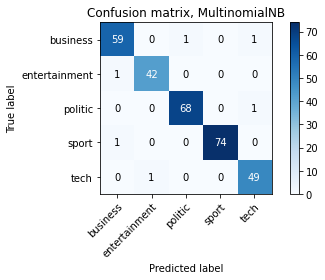

In [54]:
plot_confusion_matrix(x_test['Category'], mnb_test_predictions,target_names, normalize=False)

In [55]:
from sklearn.metrics import classification_report, confusion_matrix

classifier=mnb_classifier
predictions = mnb_test_predictions

print(classification_report(x_test.Category, predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.97      0.97      0.97        61
entertainment       0.98      0.98      0.98        43
      politic       0.99      0.99      0.99        69
        sport       1.00      0.99      0.99        75
         tech       0.96      0.98      0.97        50

     accuracy                           0.98       298
    macro avg       0.98      0.98      0.98       298
 weighted avg       0.98      0.98      0.98       298



In [ ]:
""" Analizar Naive:
Podemos observar en la matriz de confusion que el predictor con naive ha funcionado muy satisfactoriamente,
ha tenido una precision del 98%, con una exhaustividad y puntuacion f1 de 0.98"""

In [57]:
from sklearn import neighbors

knn_classifier = neighbors.KNeighborsClassifier()
knn_classifier.fit(train_vector_data, x_train.Category)

knn_train_predictions = knn_classifier.predict(train_vector_data)
knn_test_predictions = knn_classifier.predict(test_vector_data)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions == x_train.Category))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions == x_test.Category))

k-NN, porcentaje de aciertos en entrenamiento: 0.6669463087248322
k-NN, porcentaje de aciertos en test: 0.5838926174496645


Confusion matrix, MultinomialNB
[[30  0  2 29  0]
 [ 0 15  0 28  0]
 [ 0  0 44 25  0]
 [ 0  0  0 75  0]
 [ 3  5  1 31 10]]


<AxesSubplot:title={'center':'Confusion matrix, MultinomialNB'}, xlabel='Predicted label', ylabel='True label'>

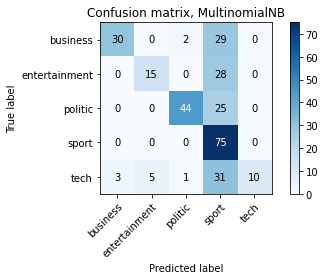

In [58]:
plot_confusion_matrix(x_test['Category'], knn_test_predictions,target_names, normalize=False)

In [59]:
classifier=knn_classifier
predictions = knn_test_predictions

print(classification_report(x_test.Category, predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.91      0.49      0.64        61
entertainment       0.75      0.35      0.48        43
      politic       0.94      0.64      0.76        69
        sport       0.40      1.00      0.57        75
         tech       1.00      0.20      0.33        50

     accuracy                           0.58       298
    macro avg       0.80      0.54      0.56       298
 weighted avg       0.78      0.58      0.57       298



In [34]:
""" Analizar KNN """

' Analizar '

## 3) Representación basada en word-embeddings

La segunda vectorización que vamos a usar representará los mensajes usando word-embeddings. Cada documento se representará como el vector que resulta de promediar los embeddings de cada una de sus palabras. Al igual que en el apartado anterior, usaremos monogramas y las _stop words_ que vienen configuradas por defecto para el inglés. Recuerda usar como vocabulario para vectorizar el vocabulario del fichero con las word-embeddings. 

Entrena un clasificador Naive Bayes Gaussiano (el Multinomial no admite valores negativos que sí aparecen en los embeddings). Analiza el error por clase y dibuja la matriz de confusión.

Entrena otro clasificador kNN con la nueva vectorización y la configuración por defecto y analiza su error.

In [61]:
from gensim.scripts.glove2word2vec import glove2word2vec
from gensim.models import KeyedVectors

model = KeyedVectors.load_word2vec_format('words.txt', binary=False, no_header=True)

In [63]:
we_vocabulary = list(model.key_to_index.keys())

In [68]:
vectorizer2 = CountVectorizer(vocabulary = we_vocabulary, stop_words='english', binary=False,ngram_range=(1,1))

In [69]:
train_data_vector2 = vectorizer2.fit_transform(x_train.Text)
test_data_vector2 = vectorizer2.transform(x_test.Text)

we_feature_names = vectorizer2.get_feature_names()

In [70]:
from sklearn.naive_bayes import GaussianNB

gnb_classifier = GaussianNB()

chunk_size=149
num_rows=len(x_train.Category)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_data_vector2[i*chunk_size : (i+1)*chunk_size,:].toarray()
    target_chunk = x_train.Category[i*chunk_size : (i+1)*chunk_size]
    gnb_classifier.partial_fit(train_chunk, target_chunk, classes=np.unique(x_train.Category))

In [71]:
gnb_train_predictions=np.zeros_like(x_train.Category)
gnb_test_predictions=np.zeros_like(x_test.Category)

for i in range(0, (num_rows//chunk_size)):
    train_chunk = train_data_vector2[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_train_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(train_chunk)
    
num_rows=len(x_test.Category)
for i in range(0, (num_rows//chunk_size)):
    test_chunk = test_data_vector2[i*chunk_size : (i+1)*chunk_size,:].toarray()
    gnb_test_predictions[i*chunk_size : (i+1)*chunk_size] = gnb_classifier.predict(test_chunk)

print("Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento:", np.mean(gnb_train_predictions == x_train.Category))
print("Gaussian Naive Bayes, porcentaje de aciertos en test:", np.mean(gnb_test_predictions == x_test.Category))

Gaussian Naive Bayes, porcentaje de aciertos en entrenamiento: 1.0
Gaussian Naive Bayes, porcentaje de aciertos en test: 0.9026845637583892


Confusion matrix, MultinomialNB
[[54  1  2  0  4]
 [ 0 41  0  0  2]
 [ 5  3 59  0  2]
 [ 1  3  2 67  2]
 [ 0  1  1  0 48]]


<AxesSubplot:title={'center':'Confusion matrix, MultinomialNB'}, xlabel='Predicted label', ylabel='True label'>

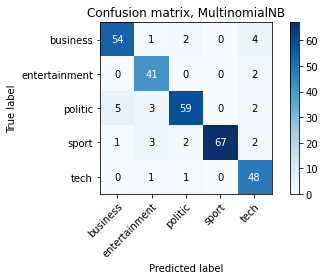

In [74]:
plot_confusion_matrix(x_test['Category'], gnb_test_predictions,target_names, normalize=False)

In [75]:
classifier=gnb_classifier
predictions = gnb_test_predictions

print(classification_report(x_test.Category, predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.90      0.89      0.89        61
entertainment       0.84      0.95      0.89        43
      politic       0.92      0.86      0.89        69
        sport       1.00      0.89      0.94        75
         tech       0.83      0.96      0.89        50

     accuracy                           0.90       298
    macro avg       0.90      0.91      0.90       298
 weighted avg       0.91      0.90      0.90       298



In [76]:
""" Texto """

' Texto '

In [77]:
from sklearn import neighbors

knn_classifier2 = neighbors.KNeighborsClassifier()
knn_classifier2.fit(train_data_vector2, x_train.Category)

knn_train_predictions2 = knn_classifier2.predict(train_data_vector2)
knn_test_predictions2 = knn_classifier2.predict(test_data_vector2)

print("k-NN, porcentaje de aciertos en entrenamiento:", np.mean(knn_train_predictions2 == x_train.Category))
print("k-NN, porcentaje de aciertos en test:", np.mean(knn_test_predictions2 == x_test.Category))

k-NN, porcentaje de aciertos en entrenamiento: 0.6057046979865772
k-NN, porcentaje de aciertos en test: 0.5335570469798657


Confusion matrix, MultinomialNB
[[24  0  0 37  0]
 [ 0 15  0 28  0]
 [ 0  0 36 33  0]
 [ 0  0  0 75  0]
 [ 3  8  0 30  9]]


<AxesSubplot:title={'center':'Confusion matrix, MultinomialNB'}, xlabel='Predicted label', ylabel='True label'>

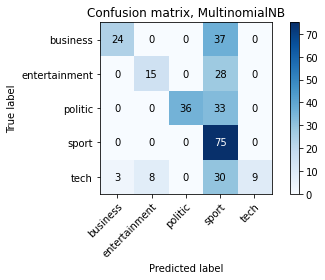

In [78]:
plot_confusion_matrix(x_test['Category'], knn_test_predictions2,target_names, normalize=False)

In [79]:
classifier=knn_classifier2
predictions = knn_test_predictions2

print(classification_report(x_test.Category, predictions, target_names=target_names))

               precision    recall  f1-score   support

     business       0.89      0.39      0.55        61
entertainment       0.65      0.35      0.45        43
      politic       1.00      0.52      0.69        69
        sport       0.37      1.00      0.54        75
         tech       1.00      0.18      0.31        50

     accuracy                           0.53       298
    macro avg       0.78      0.49      0.51       298
 weighted avg       0.77      0.53      0.52       298



## 4) Análisis comparativo final

Hemos entrenado dos clasificadores usando dos vectorizaciones diferentes de los datos. Compara la tasa de acierto de todos ellos y explica a qué crees que se deben las diferencias.

Busca un mensaje mal clasificado por el Naive Bayes con vectorización de frecuencias y otro mal clasificado por el k-NN con Word-embeddings. Analiza los vectores de términos de dichos mensajes e intenta razonar por qué ha sido clasificado erróneamente.

Para el Naive Bayes con vectorización de frecuencias, elige dos clases donde el clasificador no haya funcionado bien y analiza las palabras más relevantes para clasificar una noticia como de dichas clases. Razona si lo que ves crees que influye en la posible confusión a la hora de clasificar entre dichas clases.

In [ ]:
""" Hablar de cosas y buscar articulo mal clasificado comparando texto a texto de la predicted y 
la que ya hay y parar cuando se encuentre 

Usar el write terminos

NaiveBayes al final del notebook de clasificacion de texto"""